# Sentinel-1 processing: ship detection with eodag and snap

In  this  tutorial  we  will employ eodag for ship  detection (marine  surveillance) in the Gulf   of   Trieste   using   Sentinel-1 Satellite borne synthetic aperture radar (SAR).

Marine surveillance can be done using different technologies. A first option consists of cooperative system in which ships themselves report their identities and positions. The three most common options are Automatic Identification System (AIS), Long Range Identification and Tracking (LRIT) and Vessel Monitoring System. These systems most commonly
use cameras and radars located on a variety of platforms (ship, airplanes, satellites, etc.)*. 

Ship detection with Sentinel-1  falls  into  the  non-cooperative  category  and  enables  detection  of vessels not carrying AIS or other tracking system on board such as smaller fishing ships or ships that are  in  the  surveyed  area  illegally  (illegal  fishing,  piracy  etc.).  Moreover,  SAR  is  not  reliant  on  solar illumination and is rather   independent   of   weather   conditions, therefore enabling  frequent monitoring.

(*source: esa rus tutorials)

To be able to follow this tutorial, you will need to:
* Download the [ESA sentinel Toolbox](http://step.esa.int/main/download/) and add the location of the **gpt** binary to your PATH;
* Install [GDAL](https://pypi.org/project/GDAL/) for python and add the location of the **gdal** binary to your CPLUS_INCLUDE_PATH and C_INCLUDE_PATH;
* Download the auxiliary files [here](https://bitbucket.org/geostorm/eodag/src/master/examples/auxdata/) which contain the appropriates shapefiles.

Let's start by setting your personal credentials to access [peps service](https://peps.cnes.fr) by filling your username and password bellow:

In [1]:
import os
os.environ["EODAG__PEPS__AUTH__CREDENTIALS__USERNAME"] = "PLEASE_CHANGE_ME"
os.environ["EODAG__PEPS__AUTH__CREDENTIALS__PASSWORD"] = "PLEASE_CHANGE_ME"

Then we create a workspace directory where all our files and configuration will live:

In [1]:
from eodag.api.core import EODataAccessGateway
from eodag.utils.logging import setup_logging

setup_logging(verbose=1)

workspace = 'eodag_workspace'
if not os.path.isdir(workspace):
    os.mkdir(workspace)

dag = EODataAccessGateway()
product_type = 'S1_SAR_GRD'
extent = {
    'lonmin': 13.054504,
    'lonmax': 13.808441,
    'latmin': 45.475540,
    'latmax': 45.762733
}

We make a search centered on the ninth of October 2016 via eodag, and check results on the map:

In [2]:
products, estimated_nbr_of_results = dag.search(
    productType=product_type, 
    start='2017-05-01', 
    end='2017-05-02',
    box=extent
)

2019-03-18 17:57:28,627-15s eodag.core                       [INFO    ] Searching product type 'S1_SAR_GRD' on provider: peps
2019-03-18 17:57:28,629-15s eodag.plugins.search.qssearch    [INFO    ] Sending count request: https://peps.cnes.fr/resto/api/collections/S1/search.json?box=13.054504,45.47554,13.808441,45.762733&startDate=2017-05-01&productType=GRD&completionDate=2017-05-02&maxRecords=1&page=1
2019-03-18 17:57:29,272-15s eodag.plugins.search.qssearch    [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S1/search.json?box=13.054504,45.47554,13.808441,45.762733&startDate=2017-05-01&productType=GRD&completionDate=2017-05-02&maxRecords=20&page=1
2019-03-18 17:57:30,098-15s eodag.core                       [INFO    ] Found 2 result(s) on provider 'peps'


In [3]:
import folium

emap = folium.Map([46.6, 10.5], zoom_start=5)
layer = folium.features.GeoJson(
    data=products.as_geojson_object(), 
    style_function=lambda x: {'fillColor': 'red'}
).add_to(emap)
emap

/home/aoyono/workspace/virtualenvs/eodag27/local/lib/python2.7/site-packages/folium/__init__.py:59: UserWarning: This version of folium is the last to support Python 2. Transition to Python 3 to be able to receive updates and fixes. Check out https://python3statement.org/ for more info.
  UserWarning


We can see the different results. Product used for this tutorial is **S1A_IW_GRDH_1SDV_20170501T165806_20170501T165831_016391_01B235_9CD1**, as it cover the major part of the triest gulf.

**WARNING**: Beware with the image you use in snap processing graphs, it should be the one corresponding to the shapefiles given at the beginning of this tutorial. In the python object obtained from the search, the right image is the one with index 1. If you fail to respect this, the gpt graph ShipDetection.xml will not run.

In [4]:
for p in products:
    print(p.properties['title'])
product = products[1]

S1A_IW_GRDH_1SDV_20170501T165831_20170501T165856_016391_01B235_1399
S1A_IW_GRDH_1SDV_20170501T165806_20170501T165831_016391_01B235_9CD1


In [5]:
from eodag.utils import NotebookProgressCallback

product_path = product.download(progress_callback=NotebookProgressCallback())

2019-03-18 17:57:51,171-15s eodag.plugins.download.http      [INFO    ] Download url: https://peps.cnes.fr/resto/collections/S1/46d48388-c2c0-5fdb-b3c9-aadafeeedf76/download
2019-03-18 17:57:51,707-15s eodag.plugins.download.http      [WARNING ] Downloaded product is not a Zip File. Please check its file type before using it
2019-03-18 17:57:51,712-15s eodag.api.product                [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://peps.cnes.fr/resto/collections/S1/46d48388-c2c0-5fdb-b3c9-aadafeeedf76/download


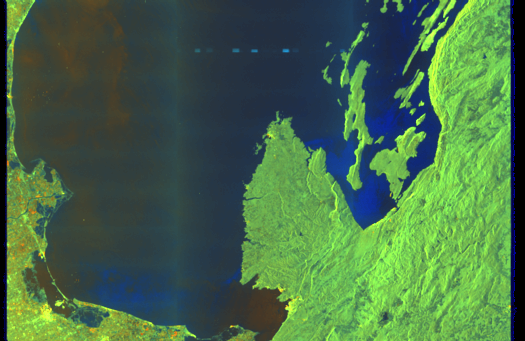

In [6]:
from IPython.display import display, Image

product_path = product_path[7:] if product_path.startswith('file://') else product_path
Image(os.path.join(product_path, 'preview/quick-look.png'))

First, we reduce the working area to a smaller one contained into the gulf. We add to the product the vector file, containing the sea-lands separation mask.

In [7]:
graph_subset = os.path.join(workspace, 'Subset.xml')
with open(graph_subset, 'w') as g_1:
    g_1.write(
"""
<graph id="Graph">
  <version>1.0</version>
    <node id="Read">
      <operator>Read</operator>
      <sources/>
      <parameters>
        <file>${inputproduct}</file>
      </parameters>
    </node>
    <node id="Subset">
      <operator>Subset</operator>
      <sources>
        <sourceProduct refid="Apply-Orbit-File"/>
      </sources>
      <parameters>
        <region>500,500,15300,16600</region>
        <copyMetadata>true</copyMetadata>
      </parameters>
    </node>
    <node id="Apply-Orbit-File">
      <operator>Apply-Orbit-File</operator>
      <sources>
        <sourceProduct refid="Read"/>
      </sources>
    </node>
    <node id="Import-Vector">
      <operator>Import-Vector</operator>
      <sources>
        <sourceProduct refid="Subset"/>
      </sources>
      <parameters>
        <vectorFile>${vectorfile}</vectorFile>
        <separateShapes>false</separateShapes>
      </parameters>
    </node>
    <node id="Write">
      <operator>Write</operator>
      <sources>
        <sourceProduct refid="Import-Vector"/>
      </sources>
      <parameters>
        <file>${outputproduct}</file>
      </parameters>
    </node>
</graph>
"""
)

In [8]:
import subprocess

vector_file = os.path.join(workspace, 'auxdata', 'Gulf_of_Trieste_seamask_UTM33.shp')
# Before calling gpt, we must set the environment
# variable LD_LIBRARY_PATH to the current directory
os.environ['LD_LIBRARY_PATH'] = '.'

subprocess.call([
    'gpt', 
    graph_subset, 
    '-Pinputproduct={}'.format(product.location[len('file://'):]),
    '-Pvectorfile={}'.format(vector_file),
    '-Poutputproduct={}'.format(os.path.join(
        workspace, 'S1A_IW_GRDH_1SDV_20161009T165807_4550_Orb'
    ))
])

0

Now we can compute the ships detection. We apply a tresholding, then a target detection, setting detection between 30 and 600m. Adaptive  thresholding  is  a  frequently  used  method  for  target  detection  in  SAR  imagery.  The underlying  assumption  is  that  targets appear  bright  on  dark  background.  The adaptive  thresholding algorithm  is  applied  in  moving  window.  For  each  pixel  under  test (central  pixel) a new  threshold value is calculated based on the statistical characteristics of its local background:if the pixel value is above the threshold the pixel is classified as target pixel.

In [9]:
graph_process = os.path.join(workspace, 'ShipDetection.xml')
with open(graph_process, 'w') as g_2:
    g_2.write(
"""
<graph id="Graph">
  <version>1.0</version>
    <node id="Read">
      <operator>Read</operator>
      <sources/>
      <parameters>
        <file>${inputproduct}</file>
      </parameters>
    </node>
    <node id="Land-Sea-Mask">
      <operator>Land-Sea-Mask</operator>
      <sources>
        <sourceProduct refid="Read"/>
      </sources>
      <parameters>
        <geometry>Gulf_of_Trieste_seamask_UTM33</geometry>
        <landMask>false</landMask>
        <useSRTM>false</useSRTM>
        <shorelineExtension>10</shorelineExtension>
      </parameters>
    </node>
    <node id="Calibration">
      <operator>Calibration</operator>
      <sources>
        <sourceProduct refid="Land-Sea-Mask"/>
      </sources>
      <parameters>
        <selectedPolarisations>VH,VV</selectedPolarisations>
        <outputSigmaBand>true</outputSigmaBand>
      </parameters>
    </node>
    <node id="AdaptiveThresholding">
      <operator>AdaptiveThresholding</operator>
      <sources>
        <sourceProduct refid="Calibration"/>
      </sources>
      <parameters>
        <targetWindowSizeInMeter>30</targetWindowSizeInMeter>
        <guardWindowSizeInMeter>500.0</guardWindowSizeInMeter>
        <backgroundWindowSizeInMeter>800.0</backgroundWindowSizeInMeter>
        <pfa>12.5</pfa>
      </parameters>
    </node>
    <node id="Object-Discrimination">
      <operator>Object-Discrimination</operator>
      <sources>
        <sourceProduct refid="AdaptiveThresholding"/>
      </sources>
      <parameters>
        <minTargetSizeInMeter>30</minTargetSizeInMeter>
        <maxTargetSizeInMeter>600</maxTargetSizeInMeter>
      </parameters>
    </node>
    <node id="Write1">
      <operator>Write</operator>
      <sources>
        <sourceProduct refid="Object-Discrimination"/>
      </sources>
      <parameters>
        <file>${outputproduct1}</file>
      </parameters>
    </node>
    <node id="Write2">
      <operator>Write</operator>
      <sources>
        <sourceProduct refid="Object-Discrimination"/>
      </sources>
      <parameters>
        <file>${outputproduct2}</file>
        <formatName>Geotiff</formatName>
      </parameters>
    </node>
</graph>
"""
)

In [10]:
subprocess.call([
    'gpt',
    graph_process, 
    '-Pinputproduct={}'.format(os.path.join(
        workspace, 'S1A_IW_GRDH_1SDV_20161009T165807_4550_Orb.dim'
    )),
    '-Poutputproduct1={}'.format(os.path.join(
        workspace, 'S1A_IW_GRDH_1SDV_20161009T165807_4550_processed'
    )),
    '-Poutputproduct2={}'.format(os.path.join(
        workspace, 'S1A_IW_GRDH_1SDV_20161009T165807_4550_processed'
    ))
])

0

Finally, we make a final subset for a visualization. 

In [10]:
graph_visu = os.path.join(workspace, 'vizualisation_ships.xml')
with open(graph_visu, 'w') as g_3:
    g_3.write(
"""
<graph id="Graph">
  <version>1.0</version>
    <node id="Read">
      <operator>Read</operator>
      <sources/>
      <parameters>
        <file>${inputproduct}</file>
      </parameters>
    </node>
    <node id="SubSet">
      <operator>Subset</operator>
      <sources>
        <sourceProduct refid="Read"/>
      </sources>
      <parameters>
        <region>0,1000,10000,10000</region>
      </parameters>
    </node>
    <node id="Terrain-Correction">
      <operator>Terrain-Correction</operator>
      <sources>
        <sourceProduct refid="SubSet"/>
      </sources>
      <parameters>
        <sourceBands>Sigma0_VH_ship_bit_msk</sourceBands>
        <nodataValueAtSea>False</nodataValueAtSea>
      </parameters>
    </node>
    <node id="Write">
      <operator>Write</operator>
      <sources>
        <sourceProduct refid="Terrain-Correction"/>
      </sources>
      <parameters>
        <file>${outputproduct}</file>
        <formatName>Geotiff</formatName>
      </parameters>
    </node>
</graph>
"""
)

subprocess.call([
    'gpt', 
    graph_visu,
    '-Pinputproduct={}'.format(os.path.join(
        workspace, 'S1A_IW_GRDH_1SDV_20161009T165807_4550_processed.dim'
    )),
    '-Poutputproduct={}'.format(os.path.join(
        workspace, 'subset_visualization'
    ))
])

0

We visualize the data on which is applied the detection (the subset area is off the port of Ravenna), and reproject it to display it on the map.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from osgeo import gdal

def warpBasic(inputImage, warpedTiff, srs,):
        cmd = ["gdalwarp",
               "-t_srs", srs,
               "-multi",
               "-q",
               "-wo", "NUM_THREADS=ALL_CPUS",
               "-r", "bilinear",
               "-overwrite",
               "-dstnodata", "None",
               "-dstalpha"]
        cmd.extend([inputImage, warpedTiff])
        subprocess.call(cmd)
warpBasic(
    os.path.join(workspace, 'subset_visualization.tif'),
    os.path.join(workspace, 'subset_visualization_3857.tif'),
    'EPSG:3857'
)

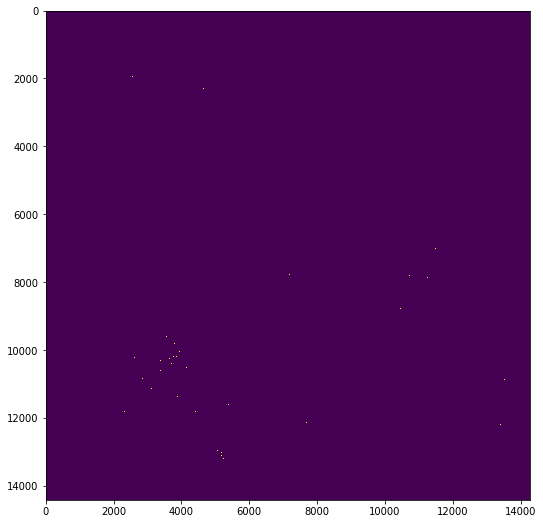

In [12]:
triest_gulf = gdal.Open(os.path.join(
    workspace, 'subset_visualization_3857.tif'
)).ReadAsArray()[0]
plt.figure(figsize=(9, 9))
im = plt.imshow(triest_gulf, vmax=0.06)

Here we have the general view of the computed ships positions in the Gulf of Trieste. We can observe the concentration of detected ships near from Ravenna harbor.

In [13]:
import csv
from itertools import islice

m = folium.Map([45, 13.6], zoom_start=8, tiles='openstreetmap')
with open(os.path.join(
    workspace, 'S1A_IW_GRDH_1SDV_20161009T165807_4550_processed.data',
    'vector_data', 'ShipDetections.csv'
), 'rt', encoding='utf-8') as data:
    for i in islice(csv.reader(data, delimiter='\t'), 2, None):
        folium.CircleMarker(
            [float(i[4]), float(i[5])], popup='Ship'
        ).add_to(m)
m

We can add the subset we've done previously and display it to see if detection worked well.

In [14]:
import imageio
import numpy as np

triest_gulf = (triest_gulf * 255) / np.max(triest_gulf)
imageio.imwrite(os.path.join(workspace, 'triest_gulf.png'), triest_gulf)

In [15]:
from folium.raster_layers import ImageOverlay

ImageOverlay(
    image=os.path.join(workspace, 'triest_gulf.png'),
    name='Mercator projection SW',
    bounds=[[44.1979166667, 12.1022944444], [45.2606388889, 13.5819333333]],
    opacity=0.9,
).add_to(m)

folium.LayerControl().add_to(m)
m

some islets appear to have been detected. Now you can modify parameters in thresholding and detection processes in order to optimize ships detection.